# 0. Initialize

## 0.1. Import Libraries

In [77]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
from google.colab import drive
drive.mount("./drive", force_remount=True)

Mounted at ./drive


In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.2. DEFINE VARIABLES 

In [80]:
DATA_PATH = './drive/My Drive/'

ROUND = 3 # This project will have 3 rounds of predictions: 1,2,3
STUDENT_ID = '25259'
PROJECT_CODE = 'CS41283a96d6e0d9f' # Same code for the annotation eg. CS412xxxxx

## 0.3. Read Training & Evaluation Data

### 0.3.1. Get the labels for tweets

In [81]:
#trainingTweetDf = pd.read_csv('{}training-tweet.csv'.format(DATA_PATH))
trainingTweetDf = pd.read_csv('./drive/My Drive/training-tweet.csv', dtype={'tweet_id': str, 'isPolitical': str})
trainingTweetDf

,tweet_id,isPolitical
0,1418828259614236672,No
1,1424439289753083911,No
2,1354305766644199427,Yes
3,1438890637282193408,Yes
4,1397543048452591616,No
...,...,...
2995,1416144676990722053,Yes
2996,1466793383788220421,Yes
2997,1448350353439744003,Yes
2998,1423327989044072453,Yes


In [82]:
trainingTweetDf.isPolitical.value_counts()

No     1509
Yes    1491
Name: isPolitical, dtype: int64

### 0.3.2. Get the labels for users

In [83]:
#trainingUserDf = pd.read_csv('{}training-user.csv'.format(DATA_PATH))
trainingUserDf = pd.read_csv('./drive/My Drive/training-user.csv')
trainingUserDf

,screen_name,isBot
0,faracyaziyor,No
1,elifgibirt,No
2,buocguldurdu,No
3,__baba1yaga_,No
4,hakanyilmazcebi,No
...,...,...
2995,kupakralicesi53,No
2996,muhamme44063672,No
2997,galaopta,Not sure
2998,hygea0,No


In [84]:
trainingUserDf.isBot.value_counts()

No          2363
Yes          401
Not sure     236
Name: isBot, dtype: int64

### 0.3.3. Expand your dataset with metadata and tweets

In [85]:
# You can also expand training data by downloading your own labeled datasets following the link
# Download the documents under "Link to training data"

print('http://www.onurvarol.com/AnnotationTwitterTR/reports/report_{}.html'.format(PROJECT_CODE))

http://www.onurvarol.com/AnnotationTwitterTR/reports/report_CS41283a96d6e0d9f.html


## 1. Landing Page

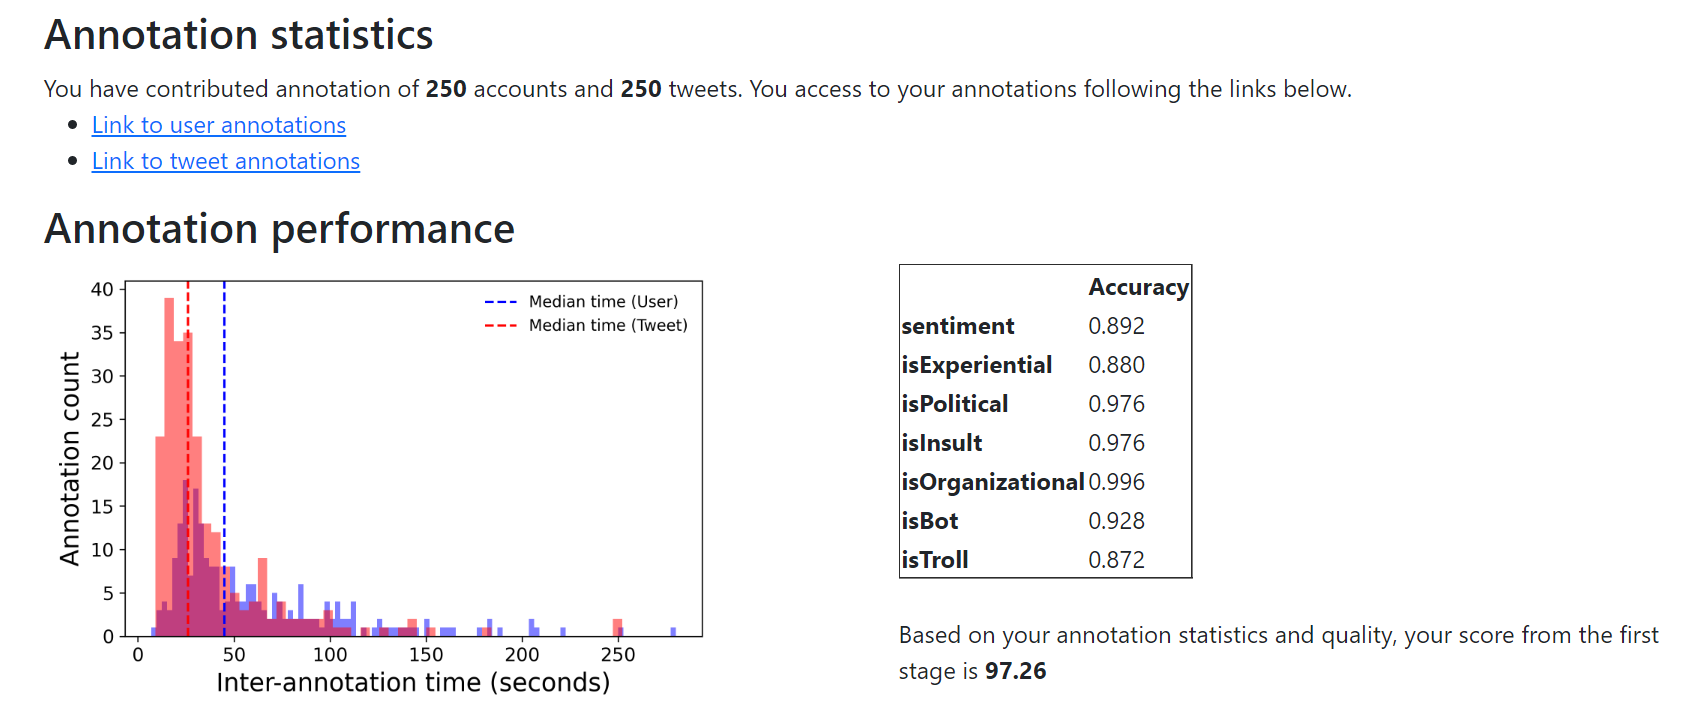

In [86]:
display.Image("https://i.imgur.com/IHvQHIf.png")

## 2. Link for Downloading Training Data

At the bottom of the page, you will see the **LINK FOR FILES**

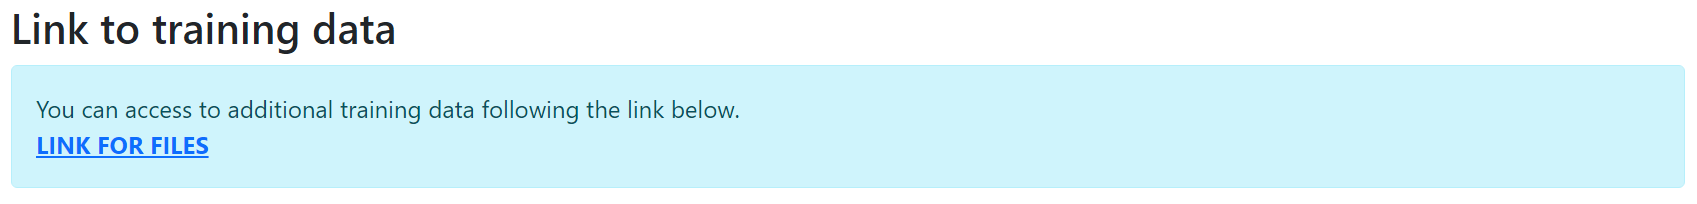

In [87]:
display.Image("https://i.imgur.com/t19vAjr.png")

## 3. Google Drive

You can download the following project files from Google Drive

- **user_profiles.jsons.gz**: Contains user metadata for bot detection phase of your project
- **user_tweets.jsons.gz**: Contains at most 200 tweets of the above mentioned users'
- **tweet_metadata.jsons.gz**: Contains tweets and their metadata for the political tweet detection of your project

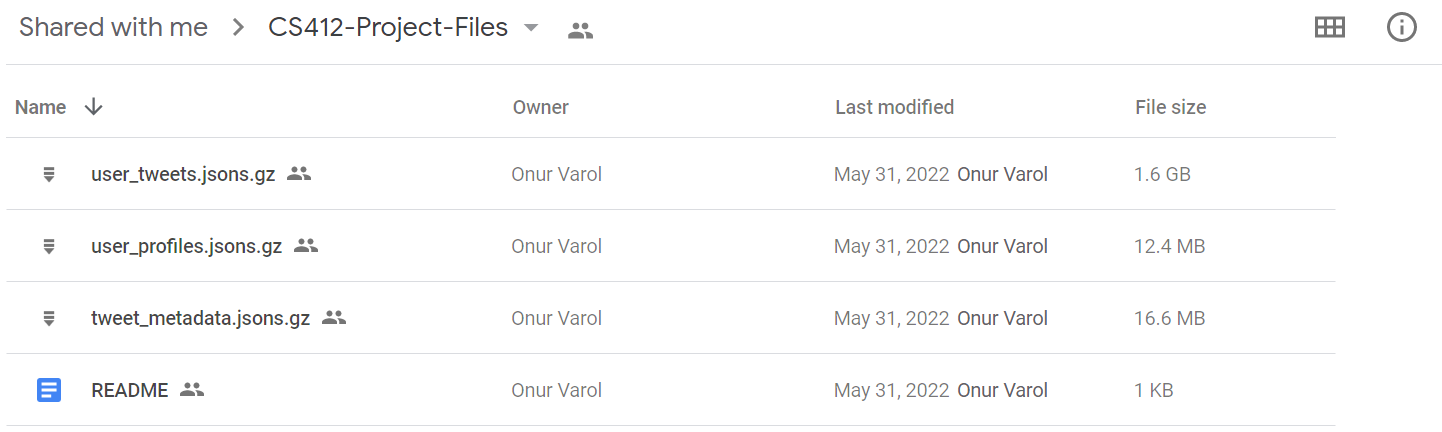

In [88]:
display.Image("https://i.imgur.com/7FjWPLi.png")

# 1. EXTRACT FEATURES
Under *1.1. Political Tweet Detection* and *1.2. Bot Detection*, we firstly collect raw data for processing. We then combine some of them (total_interactions = num_favorites + num_retweets) or use them to extract features (whether the tweet has one of the political entities @meralaksener, @kilicdarogluk etc.).

We expect you to collect more raw data from **tweet_metadata**, **user_profiles** and **user_tweets** files by creating a function as shown in below examples such as *check_if_retweet()* and using it while iterating over data as shown under *Merge Collected Features*.

We also expect you to create new variables as much as you can from the data in order to make your predictions more accurate. For example, you may want to check:

- The tweet sources that a user frequently uses
- Whether the user is a verified account or not

...

to assess whether **a user is a bot or not** and whether **a tweet is political or not**.

In [89]:
from google.colab import drive
drive.mount('/content/drive/') 
# click on the url that pops up and give the necessary authorizations

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [90]:
#import os
PATH_TO_DOWNLOADED = './drive/My Drive/'

## 1.1. Political Tweet Detection
This part stands for the feature extraction of tweets. We start with collecting the raw data from *tweet_metadata*, then use some of them to extract features.

### 1.1.1. Get Raw Data



#### 1.1.1.1. Check if Retweet

In [91]:
def check_if_retweet(tweet_metadata_line):
    is_retweet = 0
    retweeted_username = None

    try:
        tweet_metadata_line['retweeted_status']
        retweeted_username = tweet_metadata_line['retweeted_status']['user']['screen_name'].lower()
        is_retweet = 1

    except KeyError:
        pass

    return is_retweet, retweeted_username

#### 1.1.1.2. Get Tweet Text

In [92]:
def get_tweet_text(tweet_metadata_line):
    text = tweet_metadata_line['text']
    
    return text

#### 1.1.1.3. Get Tweet ID

In [93]:
def get_tweet_id(tweet_metadata_line):
    id_str = tweet_metadata_line['id_str']
    
    return id_str

#### 1.1.1.4. Get Number of Mentions and Hashtags

In [94]:
def get_number_mentions_hashtags(tweet_metadata_line):
    num_mentions = len(tweet_metadata_line['entities']['user_mentions'])
    num_hashtags = len(tweet_metadata_line['entities']['hashtags'])

    return num_mentions, num_hashtags

#### 1.1.1.5. Get Number of Retweets and Favorites

In [95]:
def get_number_retweets_favorites(tweet_metadata_line):
    retweet_count = tweet_metadata_line['retweet_count']
    favorite_count = tweet_metadata_line['favorite_count']
    
    return retweet_count, favorite_count

#### 1.1.1.6. Get User Info

In [96]:
def get_user_info(tweet_metadata_line):
    id = tweet_metadata_line['user']['id_str']
    screen_name = tweet_metadata_line['user']['screen_name'].lower()
    description = tweet_metadata_line['user']['description']

    return id, screen_name, description

1.1.1.7 Check if hashtag used

In [97]:
def check_if_hashtag(tweet_metadata_line):
  is_hashtag = 0
  if(tweet_metadata_line['entities']['hashtags'] != []):
    is_hashtag = 1
  return is_hashtag

1.1.1.8 check if tweet contain video

In [98]:
def check_if_video(tweet_metadata_line):
  is_video = 0
  try:
    if(tweet_metadata_line['extended_entities']['media'][0]['type'] == 'video'):
      is_video = 1
  except KeyError:
    pass
  return is_video

1.1.1.9 check if tweet contain a photo

In [99]:
def check_if_photo(tweet_metadata_line):
  is_photo = 0
  try:
    if(tweet_metadata_line['extended_entities']['media'][0]['type'] == 'photo'):
      is_photo = 1
  except KeyError:
    pass
  return is_photo

### 1.1.2. Derive Manually Crafted Features

#### 1.1.2.1. Check for political entity in text

In [100]:
def check_political_ent(text):
    
    # the list below can be modified and some new names may be added (or removed)
    list_of_entities = ['meral_aksener', 'kilicdarogluk', 'vekilince', 'RTErdogan', 'MevlutCavusoglu', 'umitozdag','sedat_peker']
    
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

#### 1.1.2.2. Number of total interactions

In [101]:
def total_interactions(retweet_count, favorite_count):
    total_num_interactions = retweet_count + favorite_count
    
    return total_num_interactions

### 1.1.2. Collect data using the functions above and transform into a Pandas DataFrame

In [102]:
dfPolitical = {'tweet_id':[],
              'is_retweet':[],
              'retweeted_username':[],
              'text':[],
              'num_mentions':[],
              'num_hashtags':[],
              'num_retweets':[],
              'num_favorites':[],
              'user_id':[],
              'user_screen_name':[],
              'user_description':[],
              'num_political_entities':[],
              'total_interactions':[],
              'is_hashtag':[],
              'is_video':[],
              'is_photo':[]
               }


with gzip.open(f"{PATH_TO_DOWNLOADED}tweet_metadata.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)
        
        # raw data:
        id_str = get_tweet_id(line)
        is_retweet, retweeted_username = check_if_retweet(line)
        text = get_tweet_text(line)
        num_mentions, num_hashtags = get_number_mentions_hashtags(line)
        retweet_count, favorite_count = get_number_retweets_favorites(line)
        user_id_str, screen_name, user_description = get_user_info(line)
        is_hashtag = check_if_hashtag(line)
        is_video = check_if_video(line)
        is_photo = check_if_photo(line)

        # manually crafted data:
        num_political_entities = check_political_ent(text)
        total_num_interactions = total_interactions(retweet_count, favorite_count)

        dfPolitical['tweet_id'].append(id_str)
        dfPolitical['is_retweet'].append(is_retweet)
        dfPolitical['retweeted_username'].append(retweeted_username)
        dfPolitical['text'].append(text)
        dfPolitical['num_mentions'].append(num_mentions)
        dfPolitical['num_hashtags'].append(num_hashtags)
        dfPolitical['num_retweets'].append(retweet_count)
        dfPolitical['num_favorites'].append(favorite_count)
        dfPolitical['user_id'].append(user_id_str)
        dfPolitical['user_screen_name'].append(screen_name)
        dfPolitical['user_description'].append(user_description)
        dfPolitical['num_political_entities'].append(num_political_entities)
        dfPolitical['total_interactions'].append(total_num_interactions)
        dfPolitical['is_hashtag'].append(is_hashtag)
        dfPolitical['is_video'].append(is_video)
        dfPolitical['is_photo'].append(is_photo)

In [103]:
dfPolitical = pd.DataFrame(dfPolitical)
dfPolitical

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,total_interactions,is_hashtag,is_video,is_photo
0,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0,0,0,0
1,1445677417150889986,1,ekrem_imamoglu,RT @ekrem_imamoglu: Geldikleri gibi gittiler… ...,1,0,6706,0,1263130166961864705,hasanak11633015,64 Jahre alt,0,6706,0,1,0
2,1456638729620230149,1,yenisafak,RT @yenisafak: İYİ PARTİLİ TÜRKKAN ŞEHİT AĞABE...,1,0,1545,0,2958652582,buyukdogu58,Katılıyorum: RT+FAV,0,1545,0,0,0
3,1451295314074341381,1,ekrem_imamoglu,RT @ekrem_imamoglu: Bu gece ben: ❤️💛\nTebrikle...,1,0,7470,0,1447285927471112194,gskaya444,,0,7470,0,0,0
4,1440610747134844929,1,umitozdag,RT @umitozdag: Sayın Bakan demek yüzmeyi öğren...,1,0,745,0,379944275,cerenncan,,1,745,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32997,1439639972177489926,1,deryayanikashb,RT @deryayanikashb: AK Parti Çanakkale İl Başk...,1,0,48,0,165689533,sezayicimen,İst.Aydın Üniversitesi Mahalli İdareler ve Yer...,0,48,0,0,0
32998,1467519965473423362,1,kilicdarogluk,RT @kilicdarogluk: Türkiye Barolar Birliği 36....,1,0,4438,0,408719429,sdiplen1,Hepimiz birileri için kurallarımızı çiğnedik,1,4438,0,0,0
32999,1423666826282668035,1,rterdogan,RT @RTErdogan: Geleceğe Nefes kampanyasıyla he...,1,0,14311,0,1004379711890485248,soguzsoylu,AK Parti Yumurtalık İlçe Başkanı,1,14311,0,0,0
33000,1417025303894007810,1,thetubaca,RT @thetubaca: Hasta tutuklu Ekim Polat açlık ...,3,0,16,0,1049663929348222985,mhmt_ckmk04,667 ile yılları çalınan gurebadan bir garip...,0,16,0,0,0


## 1.2. From Users

### 1.2.1. Get user metadata from user_profiles.jsons.gz

#### 1.2.1.1. Get user info metadata

In [104]:
def get_user_info_metadata(user_metadata_line):
    
    user_id = user_metadata_line['id_str']
    user_name = user_metadata_line['name']
    user_screen_name = user_metadata_line['screen_name'].lower()
    user_location = user_metadata_line['location']
    user_description = user_metadata_line['description']
    user_followers_count = user_metadata_line['followers_count']
    user_friends_count = user_metadata_line['friends_count']
    
    dictionary = {'user_id':user_id, 'user_name': user_name, 'user_screen_name':user_screen_name, 'user_location':user_location,
     'user_description':user_description, 'user_followers_count':user_followers_count, 'user_friends_count':user_friends_count}

    return dictionary

#### 1.2.1.2. Get followers/(followers+friends) ratio

In [105]:
def get_followers_all_ratio(user_followers_count, user_friends_count):
    
    if user_friends_count + user_followers_count == 0:
        followers_all_ratio = 0

    else:
        followers_all_ratio =  user_followers_count / (user_friends_count + user_followers_count)

    return followers_all_ratio

#### 1.2.1.3. Get description length

In [106]:
def get_desc_len(user_description):
    
    description_len = len(user_description)

    return description_len





1.2.1.4 Check Protected

In [107]:
def check_protected(user_metadata_line):
  is_protected = 0
  try:
    if(user_metadata_line['protected'] == True):
      is_protected = 1
  except KeyError:
    pass
  return is_protected

1.2.1.5 Check Verified

In [108]:
def check_verified(user_metadata_line):
  is_verified = 0
  try:
    if(user_metadata_line['verified'] == True):
      is_verified = 1
  except KeyError:
    pass
  return is_verified

In [109]:
dfBot = {'user_id':[],
         'user_name':[],
         'user_screen_name':[],
         'user_location':[],
         'user_description':[],
         'user_followers_count':[],
         'user_friends_count':[],
         'description_len':[],
         'followers_to_all_ratio':[],
         'is_protected':[],
         'is_verified':[]
         }

with gzip.open(f"{PATH_TO_DOWNLOADED}user_profiles.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        dictionary = get_user_info_metadata(line)
        for k,v in dictionary.items():
            dfBot[k].append(v)

        is_protected = check_protected(line)
        is_verified = check_verified(line)

        
        # manually crafted data:
        description_len = get_desc_len(dictionary['user_description'])
        dfBot['description_len'].append(description_len)
        
        followers_all_ratio = get_followers_all_ratio(dictionary['user_followers_count'], 
                                                      dictionary['user_friends_count'])

        dfBot['followers_to_all_ratio'].append(followers_all_ratio)
        dfBot['is_protected'].append(is_protected)
        dfBot['is_verified'].append(is_verified)

In [110]:
dfBot = pd.DataFrame(dfBot)
dfBot

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,is_protected,is_verified
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0,0
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0,0
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,0,0
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,1,0
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450,0,0
...,...,...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988,0,1
31817,1246020601996816385,tuncay,tuncayyilmz,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244,0,0
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859,0,0
31819,356064164,Show TV,showtv,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918,0,1


### 1.2.2. Get Tweet Info of Users in user_profiles.jsons.gz

#### 1.2.2.1. Check ratio of retweets to all tweets

In [111]:
def get_retweet_tweet_ratio(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1
                
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    if total_tweets == 0:
        retweet_total_ratio = None
    else:
        retweet_total_ratio = number_retweets/(total_tweets)
    
    return total_tweets, retweet_total_ratio

#### 1.2.2.2. Check median number of favorites

In [112]:
def get_median_number_favorites(line):
    num_median_favorites = np.median([tweet['favorite_count'] for tweet in line['tweets']])

    return num_median_favorites

### 1.2.3. Collect data using the functions above and transform into a Pandas DataFrame

In [113]:
dfBotTweets = {'user_id':[],
               'retweet_total_ratio':[],
               'num_median_favorites':[],
               'num_of_tweets':[]}

i = 0

with gzip.open(f"{PATH_TO_DOWNLOADED}user_tweets.jsons.gz", "rb") as f:
    for line in f:

        line = json.loads(line)

        user_id = line['user_id']
        dfBotTweets['user_id'].append(user_id)
        
        total_tweets, retweet_total_ratio = get_retweet_tweet_ratio(line)
        dfBotTweets['retweet_total_ratio'].append(retweet_total_ratio)
        dfBotTweets['num_of_tweets'].append(total_tweets)

        num_median_favorites = get_median_number_favorites(line)
        dfBotTweets['num_median_favorites'].append(num_median_favorites)

        i += 1
        
        if i % 10000 == 0:
            print(i)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10000
20000


In [114]:
dfBotTweets = pd.DataFrame(dfBotTweets)
dfBotTweets

,user_id,retweet_total_ratio,num_median_favorites,num_of_tweets
0,1044821071,0.090000,57.0,200
1,1086355147,0.172973,10.0,185
2,205625453,0.000000,9.0,200
3,1382717948092157953,0.356784,0.0,199
4,1302055645307375618,0.646154,0.0,195
...,...,...,...,...
29901,1865050056,0.890411,0.0,73
29902,1336329028324577281,0.783920,0.0,199
29903,1214219054329675777,0.970588,0.0,170
29904,310390437,0.875000,0.0,200


### 1.2.3. Merge dfBot and dfBotTweets

In [115]:
dfBotAll = dfBot.merge(dfBotTweets,
                       how='left')

dfBotAll[['retweet_total_ratio', 'num_median_favorites']] = dfBotAll[['retweet_total_ratio', 'num_median_favorites']].fillna(0)

dfBotAll

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,is_protected,is_verified,retweet_total_ratio,num_median_favorites,num_of_tweets
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0,0,0.060,1.0,200.0
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0,0,0.200,107.0,200.0
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,0,0,0.230,1.0,200.0
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,1,0,0.000,0.0,NaN
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450,0,0,1.000,0.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988,0,1,0.735,0.0,200.0
31817,1246020601996816385,tuncay,tuncayyilmz,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244,0,0,0.020,1.0,200.0
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859,0,0,0.000,24.0,200.0
31819,356064164,Show TV,showtv,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918,0,1,0.000,76.5,200.0


# 2. TRAIN MODEL

## 2.1. Political Tweet Prediction

### 2.1.1. Merge dfPolitical data with labels

In [116]:
dfPoliticalAll_train = dfPolitical.merge(trainingTweetDf,
                                         on='tweet_id')

dfPoliticalAll_train.head()

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,total_interactions,is_hashtag,is_video,is_photo,isPolitical
0,1422716317359083524,1,ekrem_imamoglu,RT @ekrem_imamoglu: Alarmı kurduk! Sanmayın ki...,1,1,3596,0,1151776206427234304,oykulovic,Bu terslikte bi iş var🦥,0,3596,1,0,1,No
1,1443994036847710225,1,habermujdeli,RT @HaberMujdeli: İSPARK niye zarar etsin diye...,1,0,1252,0,1029972980707860485,erefdnmez6,"Reisinin emrinde, Ak parti gönüllüsü, Vatanın,...",0,1252,0,1,0,Yes
2,1448987280740438016,1,ibrahim_yka,RT @ibrahim_yka: Hüsniye Erdoğan Mini HDP 9 8...,1,0,36,0,1381515272406900738,nurierdemli1,,0,36,0,0,0,Yes
3,1436370160731017219,1,feoist,RT @feoist: @drfahrettinkoca Allah senin çocuk...,2,0,1,0,1361792750375628800,ismail93613027,,0,1,0,0,0,No
4,1425552306104307724,1,akparti,RT @Akparti: Cumhurbaşkanımız @RTErdogan: Teme...,2,1,543,0,763812418724200448,ebru_gursultur,,1,543,1,1,0,Yes


### 2.1.2. Separate X and y values
We only use 3 features here to create a baseline model. However, it is not enough to get good results.

In [117]:
X = dfPoliticalAll_train[['num_political_entities','total_interactions','num_hashtags','is_photo','is_video']]
y = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1 if x=='Yes' else 0)

### 2.1.3. Train - validation split

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 2.1.4. Train the model

Here, you may use different models such as neural networks, XGBoost, AdaBoost, RandomForest, Linear Regression, Logistic Regression etc. to see which model does the best. Also, you can use grid_search_cv() or a basic for loop to optimize the hyperparameters of your model.

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

# create an instance
dtc_political = DecisionTreeClassifier()

# fit your model
dtc_political.fit(X_train, y_train)

# make predictions
preds = dtc_political.predict(X_valid)

# evaluate on validation set
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse = mean_squared_error(y_valid, preds)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.3016666666666667 
 Accuracy Score: 0.6983333333333334 
 Confusion Matrix: 
 [[244  42]
 [139 175]]


KNN

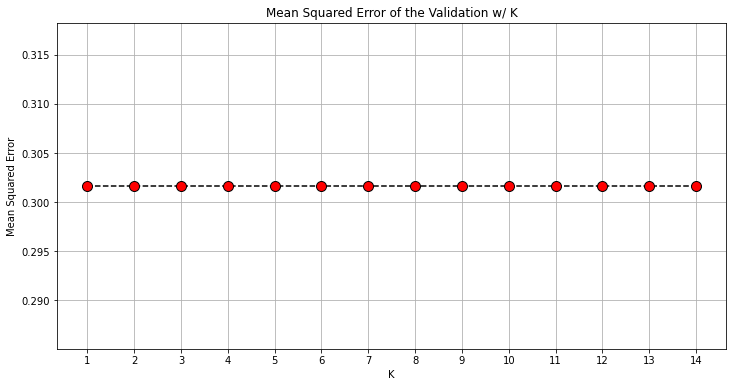

In [120]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


K_range = np.arange(1, 15)
mse_list = []

for k in K_range:
  # create a new model with current K
  knn = KNeighborsRegressor(k, metric="euclidean")
  # fit training data
  knn.fit(X_train, y_train)
  # predict the validation data
  y_pred = knn.predict(X_valid)
  # obtain the mse value
  mse = mean_squared_error(y_valid, preds)
  mse_list.append(mse)

plt.figure(figsize=(12, 6))  
plt.plot(K_range, mse_list, color='black', linestyle='dashed', marker='o',  
         markerfacecolor='red', markersize=10)
plt.title('Mean Squared Error of the Validation w/ K')  
plt.xlabel('K')  
plt.ylabel('Mean Squared Error')
plt.xticks(K_range)
plt.grid()
plt.show()

Regression Tree

In [121]:
from sklearn.tree import DecisionTreeRegressor
regression_tree=DecisionTreeRegressor(max_depth=5)
regression_tree.fit(X_train, y_train)
y_pred_train = regression_tree.predict(X_train)

print ("MSE for train value"  ,mean_squared_error(y_train, y_pred_train))

MSE for train value 0.1689629536326067


## 2.2. Bot Detection

### 2.2.1. Merge dfBotAll data with labels

In [122]:
dfBotAll.user_screen_name = dfBotAll.user_screen_name.str.lower()

In [123]:
dfBotAll_train = dfBotAll.merge(trainingUserDf,
                               left_on='user_screen_name',
                               right_on='screen_name')

dfBotAll_train

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,is_protected,is_verified,retweet_total_ratio,num_median_favorites,num_of_tweets,screen_name,isBot
0,1301168604667355142,Doğabilim,dogabilimorg,,Gerçek Bilginin Işığında!\nYayınlarımıza ulaşm...,803,93,109,0.896205,0,0,0.030000,1.0,200.0,dogabilimorg,No
1,628886610,Esra Nur ÖZDEN,esranurmuratozd,Turkey,📍Güzeller güzeli 4 melek annesi\n📍Ak Parti Ank...,1962,1650,134,0.543189,0,0,0.985000,0.0,200.0,esranurmuratozd,No
2,547532939,Kübra Şakır,kubussskr,iskenderun,'Allah'tan başka uğruna koştuğun hiçbir şey dü...,531,137,86,0.794910,1,0,0.523560,0.0,191.0,kubussskr,No
3,946826934,Gökhan İZGİ 🇹🇷🇦🇿,gokhanizgi34,"İstanbul, Türkiye",📰 Gazeteci - Yazar | 📘 S.O.S.YAL MEDYA kitabı...,42188,33979,146,0.553888,0,0,0.320000,1.0,200.0,gokhanizgi34,No
4,802201284833067009,Oral Orhon,orhonoral1975,"İstanbul, Türkiye","Holigan değil, sağlıklı ve Atatürkçü bir BEŞİK...",3988,4995,78,0.443950,0,0,0.393939,0.0,198.0,orhonoral1975,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,1338444706204835840,laito proof,vtaeskit,eu ar55 childe main,namjoon yalvaririm telefonlarimi ac,270,673,35,0.286320,0,0,0.050000,1.0,200.0,vtaeskit,No
2995,323513738,Ezgobar,shaammone,İzmir,humanoid 🏉 🏳️‍🌈,521,330,15,0.612221,0,0,0.025000,1.0,200.0,shaammone,No
2996,1451270540669378572,Havva Sert,havvasert19,,,155,199,0,0.437853,0,0,0.835052,0.0,194.0,havvasert19,No
2997,1354034188815654912,airi,airilynx,♡🧷she/her 18,#mitski ; i start the day high and it ends so ...,712,585,82,0.548959,0,0,0.120000,1.0,200.0,airilynx,No


In [124]:
trainingUserDf.isBot.value_counts()

No          2363
Yes          401
Not sure     236
Name: isBot, dtype: int64

### 2.2.2. Separate X and y values
We use only 4 features here to create a baseline model. However, it is not enough to get good results.

In [125]:
X = dfBotAll_train[['description_len', 'followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites','is_protected','is_verified']]
y = dfBotAll_train.isBot.apply(lambda x: 1 if x=='Yes' else 0)

### 2.2.3. Train-test split

In [126]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 2.2.4. Train the model

In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

# create an instance
dtc_bot = DecisionTreeClassifier()

# fit your model
dtc_bot.fit(X_train, y_train)

# make predictions
preds = dtc_bot.predict(X_valid)

# evaluate on validation set
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.3016666666666667 
 Accuracy Score: 0.7766666666666666 
 Confusion Matrix: 
 [[439  66]
 [ 68  27]]


KNN

Regression Tree

In [128]:
regression_tree=DecisionTreeRegressor(max_depth=5)
regression_tree.fit(X_train, y_train)
y_pred_train = regression_tree.predict(X_train)

print ("MSE for train value"  ,mean_squared_error(y_train, y_pred_train))

MSE for train value 0.09431383186819188


#ADABOOST

In [129]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [130]:
X_train_ada, X_valid_ada, y_train_ada, y_valid_ada = train_test_split(X, y, test_size=0.3, random_state=42)

In [131]:
AdaC = AdaBoostClassifier()
AdaC.fit(X_train_ada, y_train_ada)
print(AdaC)

AdaBoostClassifier()


In [132]:
expected_y  = y_valid_ada
predicted_y = AdaC.predict(X_valid_ada)

In [133]:
print ("MSE for train value"  ,mean_squared_error(expected_y, predicted_y))

MSE for train value 0.15666666666666668


In [134]:
AdaR = AdaBoostRegressor()
AdaR.fit(X_train_ada, y_train_ada)
print(AdaR)

AdaBoostRegressor()


In [135]:
expected_y2  = y_valid_ada
predicted_y2 = AdaR.predict(X_valid_ada)

In [136]:
print(metrics.mean_squared_error(expected_y2, predicted_y2))

0.12339098285653692


#XGBoost

In [137]:
import xgboost as xgb

In [138]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [140]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [141]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [142]:
mse = mean_squared_error(y_test, preds)
print("MSE:", mse)

MSE: 0.12387927156067953


In [143]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [144]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.328202
Name: test-rmse-mean, dtype: float64


# 3. MAKE PREDICTIONS

Here, you will make predictions with the models that you have trained above.

## 3.1. Predictions for Tweets (Political or Not)

In [145]:
# read the evaluation file as follows
evaluationTweetDf = pd.read_csv('/content/drive/MyDrive/evaluation-round3-tweet.csv', dtype={0: str}, header=None, names=['tweet_id'])
evaluationTweetDf = evaluationTweetDf.dropna()
evaluationTweetDf

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfPolitical_test = dfPolitical.merge(evaluationTweetDf)

# define X as we did above in section (2.x.2. Separate X and y values)
X = dfPolitical_test[['num_political_entities','total_interactions','num_hashtags','is_photo','is_video']]

# make predictions based on these variables
predictions_political = dtc_political.predict(X)

### This part is important! We expect you to return your predictions in the following format:

In [146]:
modelPredTweet = dict([(x,float(y)) for x,y in zip([*dfPolitical_test.tweet_id], predictions_political)])
modelPredTweet

{'1355218051214553090': 0.0,
 '1446578802507780102': 0.0,
 '1396859026705629191': 0.0,
 '1351058108651630593': 0.0,
 '1344910889741393920': 0.0,
 '1402216638926163968': 1.0,
 '1433340600544342016': 0.0,
 '1370134257490870273': 0.0,
 '1404914095254654985': 0.0,
 '1423390250932518912': 0.0,
 '1379103391561973776': 0.0,
 '1441887862262321152': 0.0,
 '1428477576436125697': 0.0,
 '1430964534865547267': 0.0,
 '1396099692392591369': 0.0,
 '1453457844834025482': 0.0,
 '1368522336543137795': 0.0,
 '1471136747916562432': 1.0,
 '1426676740659814403': 0.0,
 '1380989833452093440': 0.0,
 '1386220168293101570': 0.0,
 '1446955255971856387': 0.0,
 '1387932542804930560': 0.0,
 '1449557637318811660': 1.0,
 '1435612604278398979': 0.0,
 '1416447338202152965': 0.0,
 '1418854349451763714': 0.0,
 '1460256346624954371': 1.0,
 '1360961144769425411': 0.0,
 '1357077764533272577': 0.0,
 '1459738176520704002': 1.0,
 '1403968671425482754': 0.0,
 '1442229841898532867': 0.0,
 '1389018579006283776': 0.0,
 '135600773088

## 3.2. Predictions for Users (Bot or Not)

In [147]:
evaluationUserDf = pd.read_csv('/content/drive/MyDrive/evaluation-round3-user.csv', dtype={0: str}, header=None, names=['user_screen_name'])
evaluationUserDf = evaluationUserDf.dropna()

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfBot_test = dfBotAll.merge(evaluationUserDf)

# define X as we did above in section (2.x.2. Separate X and y values)
X = dfBot_test[['description_len', 'followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites','is_protected','is_verified']]

# make predictions based on these variables
predictions_bot = dtc_bot.predict(X)

In [148]:
modelPredUser = dict([(x,float(y)) for x,y in zip([*dfBot_test.user_screen_name], predictions_bot)])
modelPredUser

{'adnantoprak46': 0.0,
 'ay3613': 0.0,
 'hazanguzel': 0.0,
 'sabirsiztr': 0.0,
 'alonedrummer': 0.0,
 'doktoramaaktor': 0.0,
 'canimmbenimm3': 0.0,
 'muneccimsimge': 0.0,
 'koramzeynep': 0.0,
 'rabosscy': 0.0,
 'aykut190720': 0.0,
 'shadowoflower': 0.0,
 'adler16392917': 0.0,
 'alioztoprak06': 0.0,
 'taylankumelii': 0.0,
 'coldkitchen': 0.0,
 'rsrsrs97': 0.0,
 'herseyeloji': 0.0,
 'eceemsoysal': 0.0,
 'prfbaris': 0.0,
 'emell_zaim': 0.0,
 'seminanurrk': 0.0,
 'viennabjk93': 0.0,
 'neogaymyback': 0.0,
 'av_abdurrahim': 0.0,
 'theinformavore': 0.0,
 'ahmetin93': 0.0,
 'akrepkral1507': 0.0,
 'neselibalkabagi': 0.0,
 'dutal28': 0.0,
 'psychobutlogist': 0.0,
 'whiplashgirl_': 0.0,
 'senihadeyin': 0.0,
 'awwdizzy': 0.0,
 'suleymany4': 1.0,
 'canandrli': 0.0,
 'meloreco_recmel': 1.0,
 'limon99': 1.0,
 'burcusaan': 1.0,
 'bagcebariscan': 0.0,
 'kasimileri_': 1.0,
 'aytacvehbi': 0.0,
 'beyyzasx': 0.0,
 'tasduzgun': 0.0,
 'sibellzeynepp': 0.0,
 'obanioglu': 1.0,
 'fbrepublicorg': 0.0,
 'slmgkck'

# PREPARE SUBMISSION

You will need to submit exact same file produced by using the following code. Any deviation from the desired format willbe marked as 0.

In [149]:
with open('{}/{}-round{}-tweet.txt'.format("/content/drive/MyDrive", STUDENT_ID, ROUND), 'w') as fl:
    fl.write('{} - {}\n'.format(STUDENT_ID, PROJECT_CODE))
    fl.write(json.dumps(modelPredTweet))
    
    
with open('{}/{}-round{}-user.txt'.format("/content/drive/MyDrive", STUDENT_ID, ROUND), 'w') as fl:
    fl.write('{} - {}\n'.format(STUDENT_ID, PROJECT_CODE))
    fl.write(json.dumps(modelPredUser))

You can check whether you can read your predictions correctly or not:

In [150]:
with open('{}/{}-round{}-tweet.txt'.format("/content/drive/MyDrive", STUDENT_ID, ROUND), 'r') as fl:
    file = fl.read()

student_info = file.split("\n")[0]
predictions = eval(file.split("\n")[1])